# LAB 4: Working with Real Data

## Introduction

In this lab we are going to work on how to estimate the background from 'real' data. Real is in air quotes because the data is actually from simplified simulations to make the problems manageable in a single lab. But the data will have some features that resemble that of real data sets.

## Getting data and HD5

In general exchanging raw data is a pain. Writing data in text files is error prone, inaccurate, and wastes space, but raw binary files have all sorts of subtleties too (including the internal byte order of our processor). To try and sidestep a whole set of nasty issues, we are going to use HDF5 (originally developed by the National Center for Supercomputing Applications for data exchange) to import the data.

In [32]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (6,6)

In [33]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [34]:
data = np.array(hf.get('data'))

In [35]:
data[:,:10]


array([[9.40680016e+08, 9.40680016e+08, 9.40680016e+08, 9.40680016e+08,
        9.40680016e+08, 9.40680016e+08, 9.40680017e+08, 9.40680017e+08,
        9.40680017e+08, 9.40680017e+08],
       [3.15000000e+02, 3.15007112e+02, 3.15014225e+02, 3.15021337e+02,
        3.15028449e+02, 3.15035561e+02, 3.15042674e+02, 3.15049786e+02,
        3.15056898e+02, 3.15064011e+02],
       [4.50000000e+01, 4.50066667e+01, 4.50133333e+01, 4.50200000e+01,
        4.50266667e+01, 4.50333333e+01, 4.50400000e+01, 4.50466667e+01,
        4.50533333e+01, 4.50600000e+01],
       [1.00000000e+01, 8.00000000e+00, 7.00000000e+00, 1.10000000e+01,
        8.00000000e+00, 1.10000000e+01, 5.00000000e+00, 1.00000000e+01,
        9.00000000e+00, 8.00000000e+00]])

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

### Part 1 

1)We Downloaded the data from the course website (gammaray_lab4.h5), and imported it into our working environment.

The data has 4 columns and more than 25 million rows.

The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts.

We will make a few plots, generally exploring our data and making sure we understand it.WE will give a high level description of the data features we see and specifically comment on whether we see signal contamination in our data, and how we plan to build a background pdf().

Text(0, 0.5, 'count')

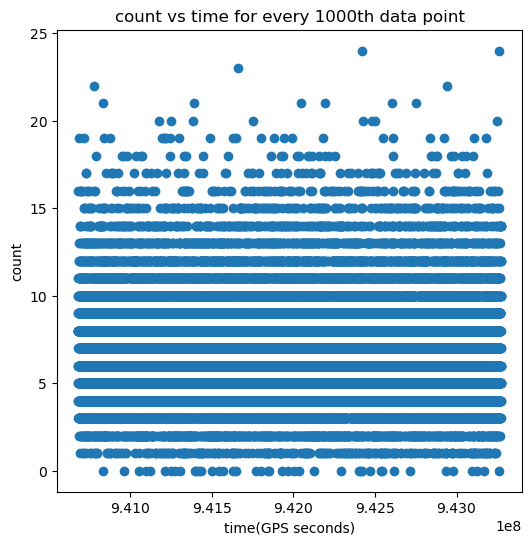

In [36]:
x = data[0,::1000]
y = data[3,::1000]
plt.scatter(x, y)
plt.title("count vs time for every 1000th data point")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")

Text(0, 0.5, 'count')

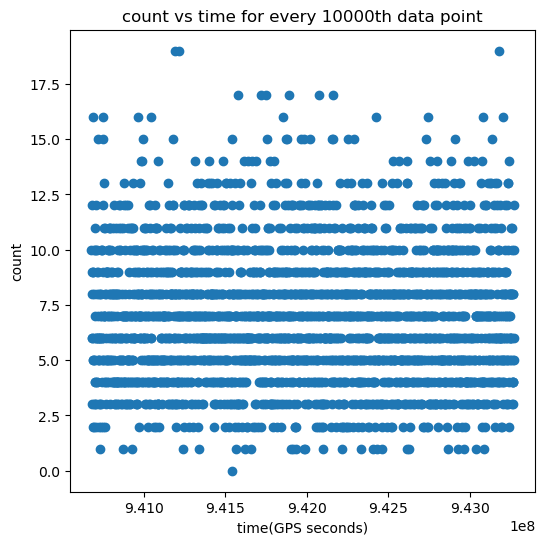

In [37]:
x = data[0,::10000]
y = data[3,::10000]
plt.scatter(x, y)
plt.title("count vs time for every 10000th data point")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")

Text(0, 0.5, 'count')

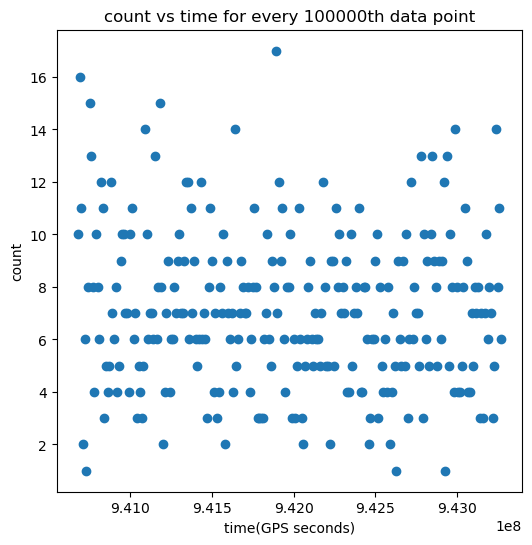

In [38]:
x = data[0,::100000]
y = data[3,::100000]
plt.scatter(x, y)
plt.title("count vs time for every 100000th data point")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")

The plot for count vs time seems to have a periodic variability which makes sense as the time period for the orbit is 90 minutes which is 90 * 60 = 5400 GPS seconds.As we have data for every 100 milliseconds. The data for 1 time period would correspond to 54000 rows.

plotting for 1 time period:

Scatter Plot:

Text(0, 0.5, 'count')

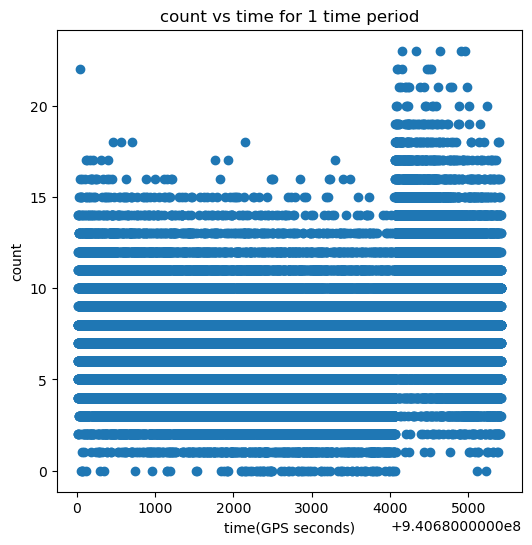

In [39]:
x = data[0,:54000]
y = data[3,:54000]
plt.scatter(x, y)
plt.title("count vs time for 1 time period")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")

2D Histogram:

Text(0, 0.5, 'count')

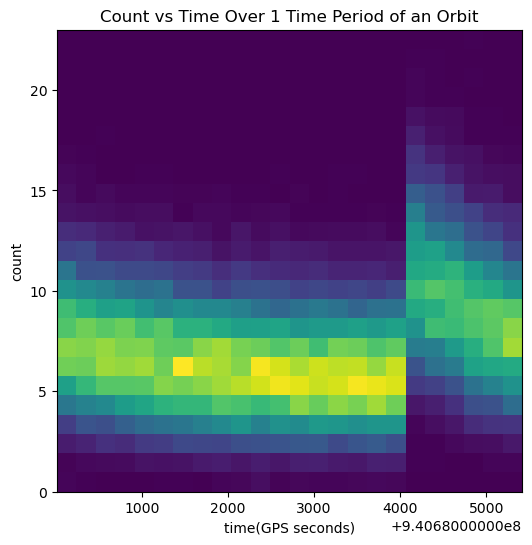

In [40]:
data = np.array(hf.get('data'))


times = data[0,:54000]

y = data[3,:54000]
plt.hist2d(times, y, bins = 24)
plt.title("Count vs Time Over 1 Time Period of an Orbit")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")

When we plot for 1 time period we can see that there is a spike for number of counts at a particular time thus we can say that there is signal contamination in the data.

In [ ]:
data = np.array(hf.get('data'))
orbit_period = 90*60*10

times = data[0, 50000: 250000]

y = data[3,50000:250000]
plt.hist2d(times % 54000, y, bins = 28)
plt.title("Count vs Time Over 4 Time Periods of an Orbit")
plt.xlabel("time folded(GPS seconds)")
plt.ylabel("count")

We see the spike 4 times when we plot the data for 4 Time Periods thus, we can say that there is a spike every period.

In [ ]:
x = data[0,:1200000]
y = data[2,:1200000]
plt.scatter(x, y)
plt.title("Earth longitude (deg) vs time(GPS seconds)")
plt.xlabel("time(GPS seconds)")
plt.ylabel("Earth longitude (deg)")

In [ ]:
x = data[0,:1200000]
y = data[1,:1200000]
plt.scatter(x, (y))
plt.title("sun phase (deg) vs time(GPS seconds)")
plt.xlabel("time(GPS seconds)")
plt.ylabel("sun phase (deg)")

We can see that the both the Earth phase and sun phase increase with the increase in time till 359 then set back to 0. this makes sense as the maximum nummerical valu is 359 and the minimum is 0. A measurement of 360 is equivalent to 0.There are no outliers thus we can say that there seems to be no contamination in this part of the data.

We are looking at the distribution of partical counts,thus we can say that the distribution would be discrete.Hence,the pdf of the background would either be binomial or poisson. As binomial can only be used for the distribution of probability of success or failure of an item, binomial doesn't make sense here as we want to find the distribution of number of counts of particles.Thus, poisson seems like a reasonable option here. Let's compare the background distribution to a poisson distribution with the same mean.

In [ ]:
h, bins, patches = plt.hist(data[3,:], density=True, bins=30)
mu = np.mean(data[3,:])
x = np.arange(0,30)
plt.stairs(stats.poisson.pmf(x,mu), color='r', label='Poisson distribution')
plt.title('Background distribution compared with a Poisson distribution of the same mean')
plt.ylabel('Probability')
plt.xlabel('Counts')
plt.legend()

plt.show()


In [ ]:
h, bins, patches = plt.hist(data[3,:], density=True, bins=30)
mu = np.mean(data[3,:])
x = np.arange(0,30)
plt.stairs(stats.poisson.pmf(x,mu), color='r', label='Poisson distribution')
plt.title('Background distribution compared with a Poisson distribution of the same mean with log y axis')
plt.ylabel('Probability')
plt.xlabel('Counts')
plt.legend()
plt.yscale('log')
plt.show()
mu

Looking at both the plots we can say that the distribution is close to that of poisson with the same mean (7).The variation of the distribution from poisson could be due to the spike in number of counts at a particular time.


### Part2

In [ ]:
data = np.array(hf.get('data'))


times = data[0,:54000]

y = data[3,:54000]
plt.hist2d(times, y, bins = 24)
plt.title("Count vs Time Over 1 Time Period of an Orbit")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")
plt.show()
h, bins, patches = plt.hist(data[3,:], density=True, bins=30)
mu = np.mean(data[3,:])
x = np.arange(0,30)
plt.stairs(stats.poisson.pmf(x,mu), color='r', label='Poisson distribution')
plt.title('Background distribution compared with a Poisson distribution of the same mean')
plt.ylabel('Probability')
plt.xlabel('Counts')
plt.legend()

plt.show()


From the above 2 plots you can see that the pdf of the background closely matches the poisson distribution. A poisson distribution is described by only one parameter which is the mean (mu).From the 2D histogram for count vs time in 1 period we can see that the mean of the count varies with time.The mean seems to exponentially decay with time, spike once during each cycle then again exponentially decay with time. For convinience we can define each cycle with the beginning of each spike.

### Part 3

In [ ]:
data = np.array(hf.get('data'))


times = data[0, 59500:94500]

y = data[3,59500:94500]
plt.hist2d(times, y, bins = 20)
plt.title("Count vs Time Over 1 Time Period of an Orbit Starting at the Spike")
plt.xlabel("time(GPS seconds)")
plt.ylabel("count")
plt.colorbar()
h, xedges, yedges, _ = plt.hist2d(times, y, bins = 10)
ave = []
for i in h:
    total = 0
    for n in range(len(i)):
            total+=n*i[n]
    ave.append(total/len(i)/1.7e2)
plt.plot(xedges[1:], ave, c='r', label='Average')
xk =  data[0,59500:94500]
plt.plot(xk, 2 * np.exp(-.001 * (((xk - 360) % 5400))) + 5.6 , c = 'k', label= 'exponent')
#plt.plot(xk, (np.exp(((-.*(xk - 145 ) * np.pi * 2)/ 360))) + 6, c = 'k')
plt.legend()
plt.show()
#.00097
#data[0,59500]

count = 2 * e^(-.001 * ((t - 360) % 5400)) + 5.5

After shifting the phase of count vs time. We can see that the mean of the distribution can be modelled as a decreasing exponential function with time with the formulae count = 2 * e^(-.001 * ((t - 360) % 5400)) + 5.5. As we can see in the above graph this function is a pretty good model of the background

### Part 4

To observe how the '5-sigma' threshold for a 100 millisecond GRB varies with time we get the probability that corresponds to the 5 sigma and then take the inverse of the survival function for the poisson distribution with the mean as a function of time

In [ ]:
x = np.linspace(0,5400,1000)
p = stats.norm.sf(5)
def sigma(t, p):
     mu = 2 * np.exp(-.001 * ((t - 360) % 5400)) + 5.5
     return stats.poisson.isf(p, mu)
plt.plot(x, sigma(x, p))
plt.title('5 sigma threshold')
plt.ylabel('Mean gamma ray count')
plt.xlabel('time(GPS seconds)')
plt.show()


In [ ]:
hf.close()

## Problem 2

In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images,We will be looking at the signal for the faintest stars.

### Part 1

First lets download and load the data into our notebook:

In [ ]:
# first lets load our data
hf = h5py.File('images.h5', 'r')
imagestack = np.array(hf.get('imagestack'))

In [ ]:
imagestack[:2:]

### Part 2
We will explore the data and see if there is signal contamination? background time dependent?consistent spatially? and develop a plan to calculate your background pdf().

To explore our data we will begin by looking at all 10 of the images taken:

In [ ]:
plt.rcParams["figure.figsize"] = (10,25)

for i in range(0, 10):
    plt.subplot(5, 2, i+1)
    
    plt.title(f' Telescope Image {i+1}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tick_params()
    plt.imshow(imagestack[:,:,i])
plt.suptitle('All images')
plt.show()

Let's look at the sum of all the images

In [ ]:
sumt = 0

for i in range(0, 10):
    sumt += imagestack[:,:,i]
plt.title("Sum Image")
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(sumt)
    

Let's look at the average of all the images

In [ ]:
sumt = 0

for i in range(0, 10):
    sumt += imagestack[:,:,i]
avg = sumt/10    
plt.title("Average Image")
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(avg)
    

Let's also observe data for different slices of the same stack.I am going to explore this along one dimension because it was sufficient for this question.

In [ ]:
plt.rcParams["figure.figsize"] = (5,6)
fig,ax=plt.subplots()
for i in range(0, 10):
    ax.hist(imagestack[:,:,i][0], alpha=0.2, bins=15)
plt.title("different slices of data for the same stack")
plt.xlabel('pixel value')
plt.ylabel('count')

plt.show()   

In [ ]:
plt.rcParams["figure.figsize"] = (5,6)
fig,ax=plt.subplots()
for i in range(0, 10):
    ax.hist(imagestack[:,:,i][0], alpha=0.2, bins=15)
plt.title("different slices of data for the same stack on log scale")
plt.xlabel('pixel value')
plt.ylabel('count')
plt.yscale('log')
plt.show()  

If there was data contamination then different slices of the same stack will have noticebly different data profiles. Looking at our data the only contamination is seen by the bar at around pixel 1.7. Thus we can say that there is little data contamination.The sum and the average plots to not show any strange defects thus we can say that our data is consistent spacially else the sum and average plots would have double images of stars.

To see whether there is time dependence let's observe the background distribution along one axis. If there is no time dependence the central mean should stay the same.

In [ ]:
plt.rcParams["figure.figsize"] = (10,12)
x = np.arange(0,200)
d = []

for i in range(0,10):
    image = []
    for j in range(0,200):
        for k in range(0,200):
            image.append(imagestack[j,k,i])
    d.append(image)
    
plt.hist(d[0], bins=100, density=True)
plt.hist(d[1], bins=100, density=True)
plt.hist(d[2], bins=100, fill=False, density=True)
plt.axvline(2.5, linestyle='--', label='Approximate end of background distrbution')
plt.yscale('log')
plt.title('Probability Distribution of Pixel Value')
plt.ylabel('Probability')
plt.xlabel('Pixel value')
plt.legend()
plt.show()

As the central mean changes slightly we can say that the background distribution is slightly time dependent, but not too much. For the background pdf I will remove the values with pixels greater than 2.5 .And then covolve the backgrounds for all the images. 

In [ ]:
background_one = d[0]


for i in range(len(background_one)):
    if background_one[i] > 2.5:
        background_one[i] = 0

for j in range(1,10):
    background2 = d[j]
    for i in range(len( background2)):
        if background2[i] > 2.5:
            background2[i] = 0
    np.convolve(background_one,background2)
x = np.linspace(-3,3, 1000)
plt.hist(background_one, bins=20, density=True)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=0.56), label='Gaussian')
plt.yscale('log')
plt.title('Background distribution')
plt.ylabel('Probability density')
plt.xlabel('Pixel value')
plt.legend()
plt.show()

Thus we can say the pdf of our background has a gaussian distribution with mean as 0 and std = .56

### Part 3

In order to hunt for our signal we will get the average of all data points and the threshold intensity for a 5 sigma detection and get the number of points on the average plot that fall of the range of the 5 sigma threshold

In [ ]:
sumt = 0

for i in range(0, 10):
    sumt += imagestack[:,:,i]
avg = sumt/10    
plt.title("Average Image")
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(avg)

The standard deviation of background pdf average of 10 plots is 5.6/(10^.5) the mean value would be 0.

In [ ]:
prob = stats.norm.sf(5, loc=0, scale=1)
value = stats.norm.isf(prob, loc = 0, scale = 5.6/(np.sqrt(10)))
value

In [ ]:
Total_count = 0
count_of_signals = 0
for i in range(200):
    for j in range(200):
        
        val = avg[i,j]
        if val > 0 :
            Total_count = Total_count + 1
        if (val >= value)  :
            count_of_signals = count_of_signals + 1
Total_count 


In [ ]:
count_of_signals

Thus, the number of stars detected = 59

### Part 4

As I have searched for fainted stars I worked on averaging the intensities over the time as they are searching for transient they will work with data that is given by the difference of 2 plots.Thus the background of our data will be different.

In [ ]:
hf.close()

In [1]:
import os
os.system('jupyter nbconvert --to html lab4.ipynb')

0